In [1]:
from commons import *
from libruntimepredictionanalysis import *
from tqdm import tqdm_notebook as tqdm

In [2]:
# read in data
df = pd.read_csv("classifier_runtimes_nooutliers.csv").query("traintime > 0")
df

Unnamed: 0  openmlid  datapoints  trainpoints  testpoints  seed  \
0                0     41066        1567            1        1566     0   
1                1     41066        1567            1        1566     1   
2                2     41066        1567            2        1565     0   
3                3     41066        1567            2        1565     1   
4                4     41066        1567            1        1566     2   
...            ...       ...         ...          ...         ...   ...   
761044     1688919      1120       19020         9000       10020     9   
761045     1688925      1120       19020        10000        9020     8   
761046     1688927      1120       19020        15000        4020     7   
761047     1688929      1120       19020        10000        9020     9   
761048     1688937      1120       19020        15000        4020     8   

       classifier  traintime  testtime exception  
0        bayesnet        1.0       2.0       NaN  
1        bayesnet        1.0       2.0       NaN  
2        bayesnet        1.0       2.0       NaN  
3        bayesnet        1.0       2.0       NaN  
4        bayesnet        1.0      86.0       NaN  
...           ...        ...       ...       ...  
761044      zeror        1.0       0.0       NaN  
761045      zeror       41.0       0.0       NaN  
761046      zeror        1.0       1.0       NaN  
761047      zeror       41.0       0.0       NaN  
761048      zeror        1.0       0.0       NaN  

[761049 rows x 10 columns]

In [3]:
# Compute, for each dataset, the datapoints for the 70/30 split
datasets = df[["openmlid", "datapoints"]].drop_duplicates().values
classifiers = np.unique(df[["classifier"]].values)
trainsizes = pd.unique(df["trainpoints"])

# 1. Preliminaries: Classifier Runtime Visualizations

## 1.1. Train- and Prediction/Application times against Trainpoints
Idea: Most algorithms are probably *either* fast in training *or* in predicting. That means that test times of slow-training algorithms are negligibly why prediction-times of slow-predictors can be precisely estimated by training the model an predicting k (k small) instances and interpolating exploiting linearity of total test time.

To this end, we want to know:
* what is, for each classifier, the test time per instance for different train sizes?

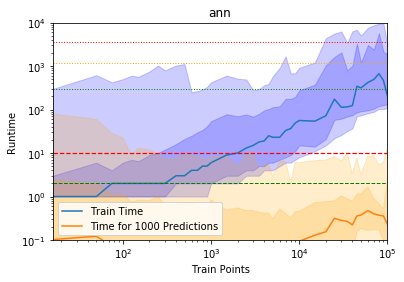

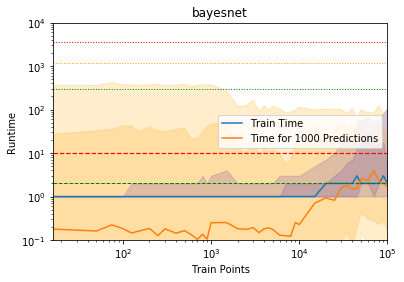

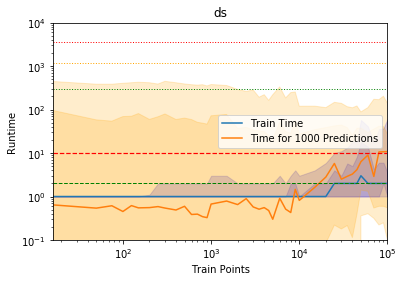

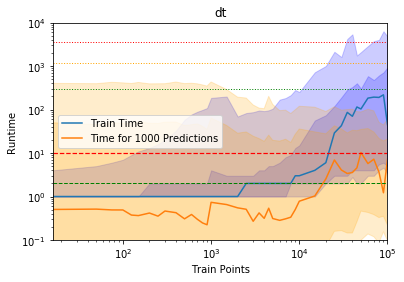

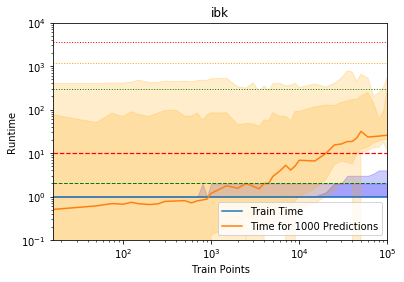

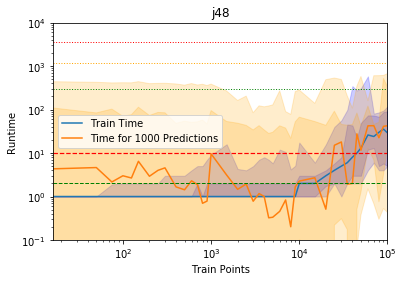

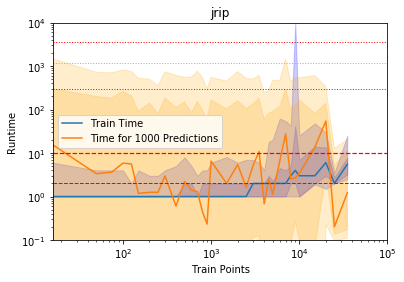

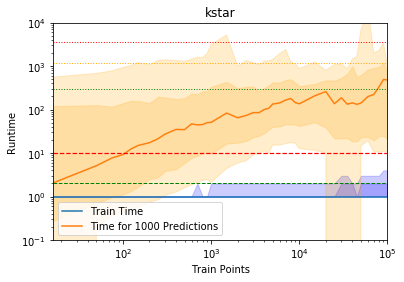

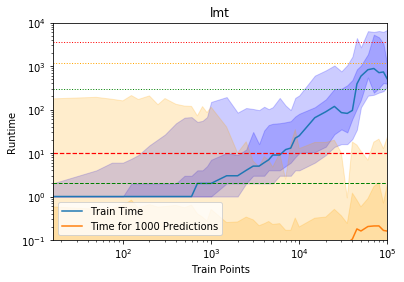

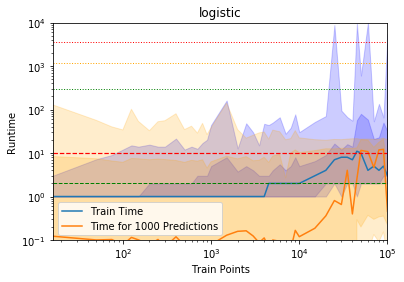

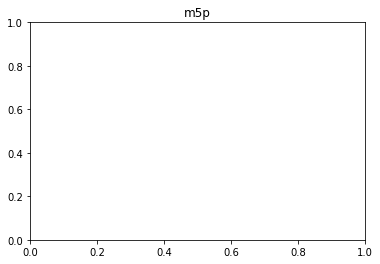

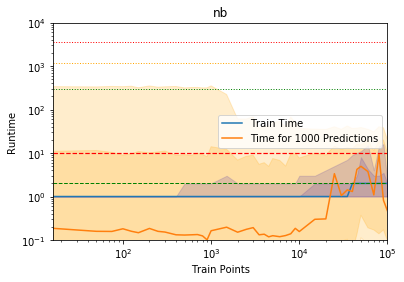

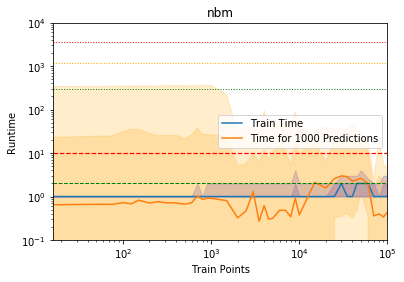

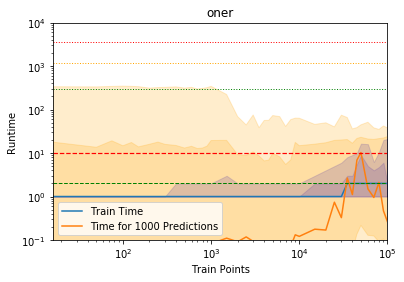

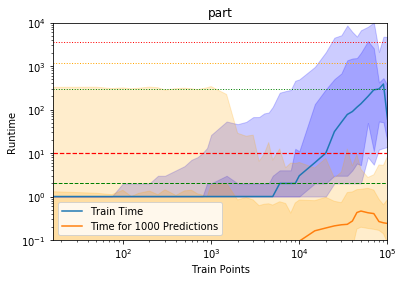

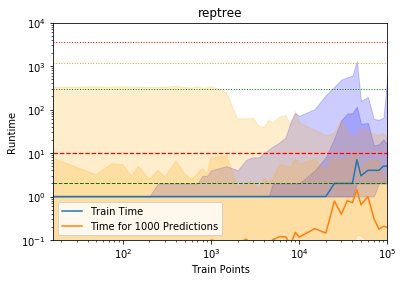

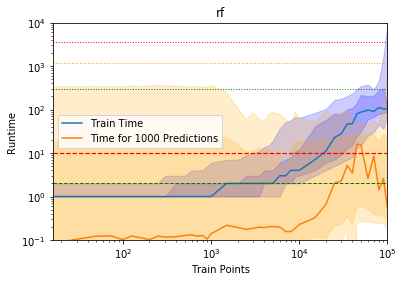

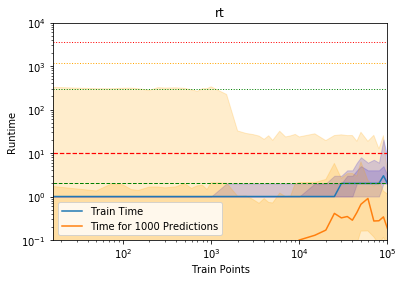

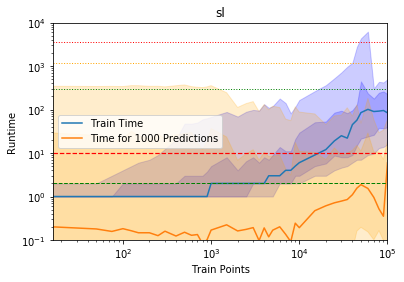

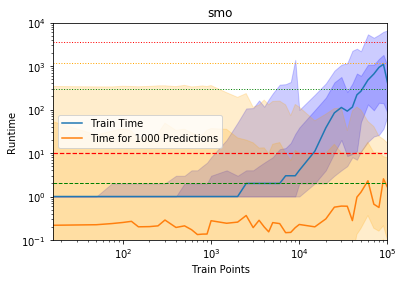

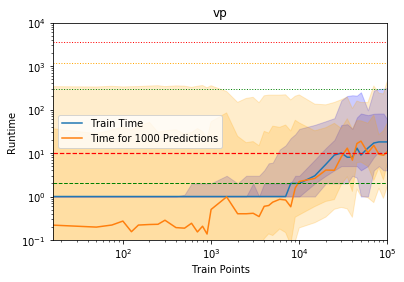

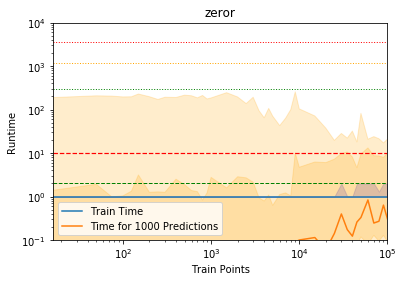

In [4]:
numPredictions = 1000
legend=["Train Time", "Time for " + str(numPredictions) +" Predictions"]
for i, c in enumerate(classifiers):
    cData = df.query("classifier == '" + c + "'")
    trainpoints = np.unique(cData["trainpoints"].values)
    trainpoints = trainpoints[trainpoints >= 10]
    q1aPointsY = []
    q3aPointsY = []
    q1bPointsY = []
    q3bPointsY = []
    medianPointsY = []
    q1aPointsZ = []
    q3aPointsZ = []
    q1bPointsZ = []
    q3bPointsZ = []
    medianPointsZ = []
    validTrainPoints = []
    #pointsY = []
    for tp in trainpoints:
        rData = cData.query("trainpoints == " + str(tp))
        y = numPredictions * rData["testtime"] / rData["testpoints"]
        y = y[~np.isnan(y)]
        z = rData["traintime"]
        #for i, v in enumerate(y):
        #    print(v)
        if len(y) > 4:
            validTrainPoints.append(tp)
            q1aPointsY.append(np.quantile(y, 0.1))
            q1bPointsY.append(np.quantile(y, 0.25))
            medianPointsY.append(np.median(y))
            q3aPointsY.append(np.quantile(y, 0.9))
            q3bPointsY.append(np.quantile(y, 0.75))
            
            q1aPointsZ.append(np.quantile(z, 0.1))
            q1bPointsZ.append(np.quantile(z, 0.25))
            medianPointsZ.append(np.median(z))
            q3aPointsZ.append(np.quantile(z, 0.9))
            q3bPointsZ.append(np.quantile(z, 0.75))
            #print(str(tp) + ": " + str(v))
        #meanPoints.append(np.mean(y))
        #pointsY.append(v)

    plt.figure()
    plt.title(c)# + " (train prediction RMSE quantile for 30s/1m/2m/5m/20m error: " + str(np.round(sp.stats.percentileofscore(metricRMSETrain[:,i], 30), 2)) + "/" + str(np.round(sp.stats.percentileofscore(metricRMSETrain[:,i], 60), 2)) + "/" + str(np.round(sp.stats.percentileofscore(metricRMSETrain[:,i], 120), 2)) + "/" + str(np.round(sp.stats.percentileofscore(metricRMSETrain[:,i], 300), 2)) + "/" + str(np.round(sp.stats.percentileofscore(metricRMSETrain[:,i], 1200), 2)) + ")")
    #plt.boxplot(points, 0, '')
    if len(q1aPointsY) > 0:
        #plt.plot(validTainPoints, q1Points)
        plt.plot(validTrainPoints, medianPointsZ)
        plt.fill_between(validTrainPoints, q1aPointsZ, q3aPointsZ, color="blue",alpha=0.2)
        plt.fill_between(validTrainPoints, q1bPointsZ, q3bPointsZ, color="blue", alpha=0.2)
        plt.plot(validTrainPoints, medianPointsY)
        plt.fill_between(validTrainPoints, q1aPointsY, q3aPointsY, color="orange", alpha=0.2)
        plt.fill_between(validTrainPoints, q1bPointsY, q3bPointsY, color="orange", alpha=0.2)
        plt.axhline(10, color="red", linestyle="--", linewidth="1.2")
        plt.axhline(2, color="green", linestyle="--", linewidth="1")
        plt.axhline(300, color="green", linestyle=":", linewidth="1")
        plt.axhline(1200, color="orange", linestyle=":", linewidth="1")
        plt.axhline(3600, color="red", linestyle=":", linewidth="1")
        #plt.plot(validTainPoints, q3Points)
        #plt.xticks(trainpoints)
        #plt.scatter(trainpoints, meanPoints, color="green")
        #if len(points) > 0:
        plt.xlabel("Train Points")
        plt.ylabel("Runtime")
        plt.xscale("log")
        plt.xlim([16,100000])
        plt.ylim([0.1,10000])
        plt.yscale("log")
        plt.legend(legend)
    plt.show()
    plt.close()
        

**Conclusion**: The above figures suggest that the following classifiers have, even for large data, negligible train time (never more than 10s) and ...
* ... prediction time increasing with more train datapoints:
 * ibk
 * kstar
* ... constant prediction time:
 * nb
 * nbm
 * rt
 
The following algorithms have high train time (*all* of them have a prediction time that is independent of the used train data):
* ann (great train time predictability)
* bn (poor train time predictability)
* ds (poor train time predictability)
* dt (great train time predictability)
* j48 (great train time predictability)
* jrip (medium train time predictability)
* lmt (medium train time predictability)
* logistic (poor train time predictability)
* oner (medium train time predictability)
* part (medium train time predictability)
* rf (poor train time predictability)

## 1.2. Runtimes against (a) train size AND (b) number of numeric features

In [5]:
## create experiment data frame
#prepareRuntimeKnowledge()
mfdf = pd.read_csv("classifierruntimes_with_meta_features.csv")
mfdf["predictiontimeperinstance"] = mfdf["testtime"] / mfdf["testpoints"]
datasetsForWhichRuntimeIsAvailable = pd.unique(mfdf[["openmlid"]].values[:,0])

In [6]:
overviews = {}

In [7]:
def getAttributeForAttributesOfAlgorithm(algorithm):
    return "numericattributesafterbinarization" if algorithm in ["lmt", "logistic", "m5", "ann", "simplelogistic", "smo"] else "numattributes" 

def getRuntimePlotData(algorithm):
    attributeForAttributes = getAttributeForAttributesOfAlgorithm(algorithm)
    classifierData = mfdf.query("classifier=='" + algorithm + "'")
    trainpoints = np.unique(classifierData["trainpoints"])
    attributes = np.unique(classifierData[attributeForAttributes])
    
    #plt.figure()
    traintimes = np.empty((len(trainpoints), len(attributes)), dtype=object)
    testtimes = np.empty((len(trainpoints), len(attributes)), dtype=object)
    for i, tp in enumerate(trainpoints):
        for j, at in enumerate(attributes):
            vals = classifierData.query("trainpoints == " + str(tp) + " and " + attributeForAttributes + " == " + str(at))
            if len(vals) > 0:
                traintimes[i][j] = vals["traintime"].values
                testtimes[i][j] = vals["predictiontimeperinstance"].values
            else:
                traintimes[i][j] = float('nan')
                testtimes[i][j] = float('nan')
    return traintimes, testtimes

def tableMean(table):
    m = table.shape[0]
    n = table.shape[1]
    out = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            out[i,j] = np.median(table[i,j])
    return out

In [12]:
for alg in tqdm(np.unique(mfdf["classifier"].values)):
    overviews[alg] = getRuntimePlotData(alg)

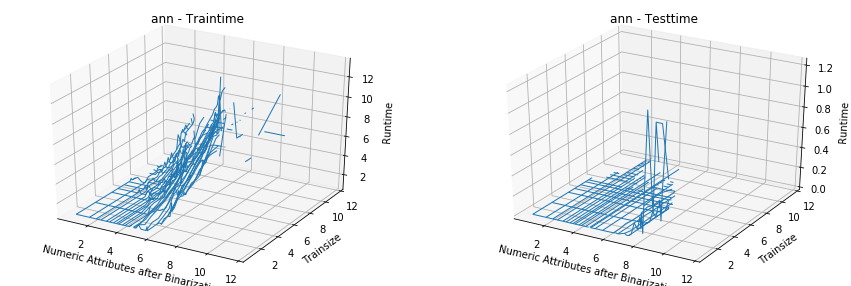

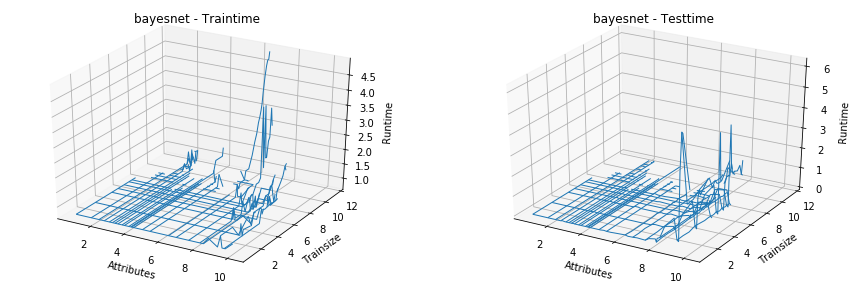

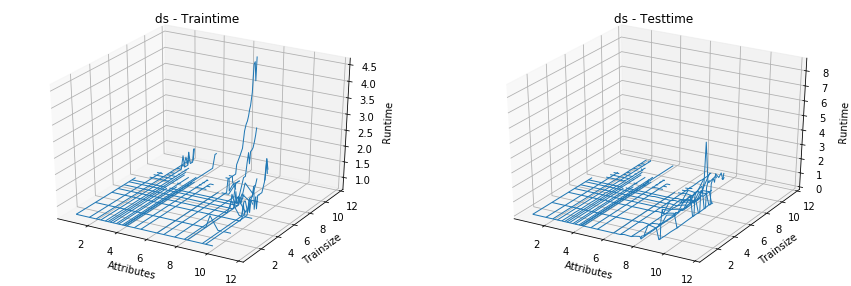

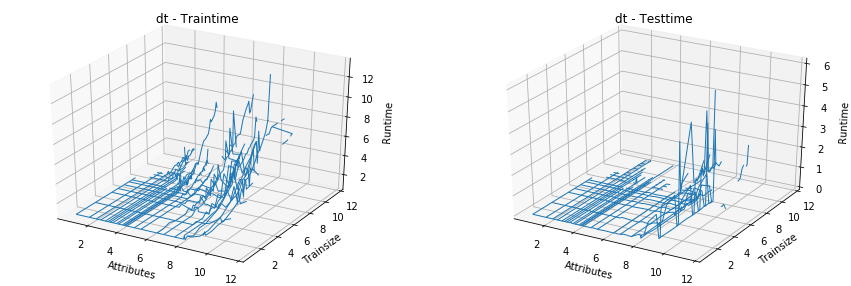

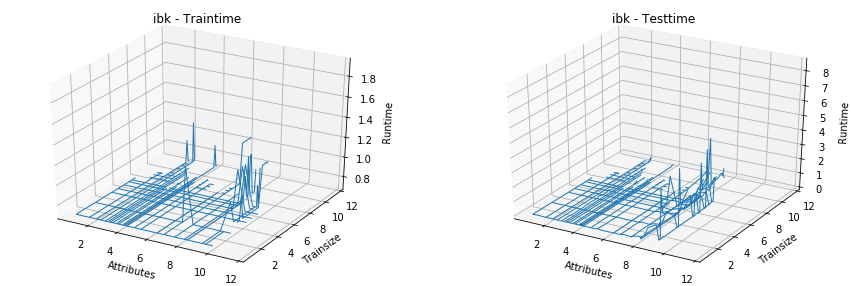

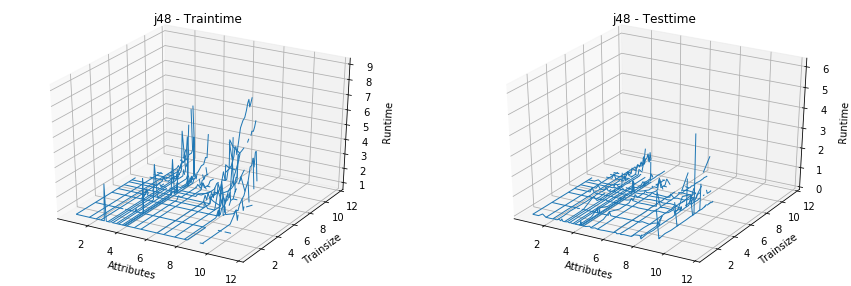

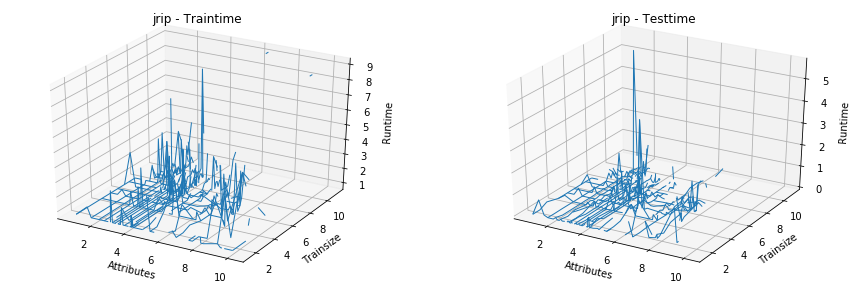

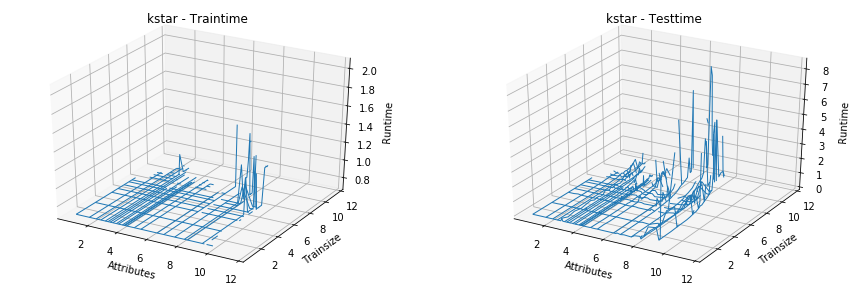

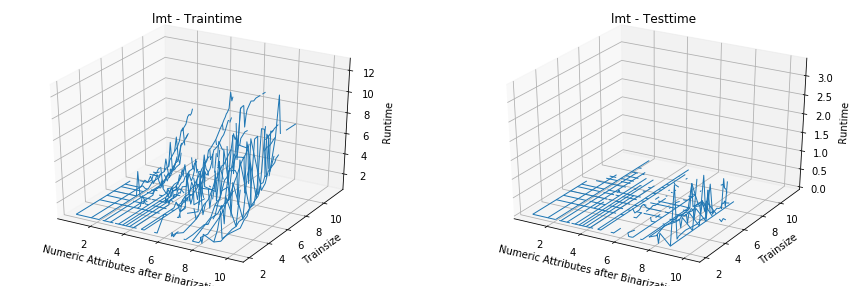

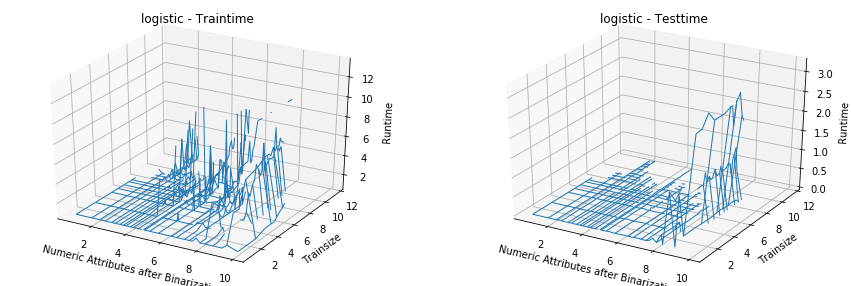

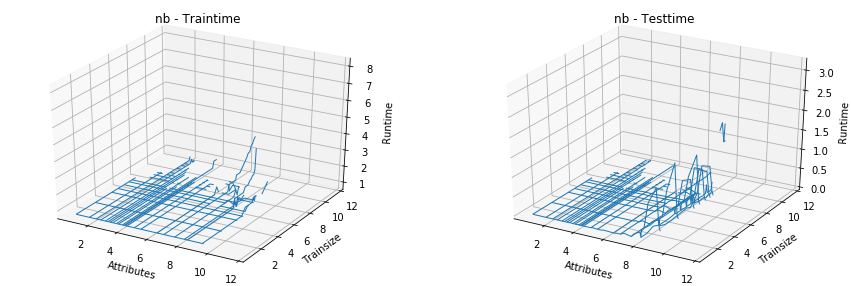

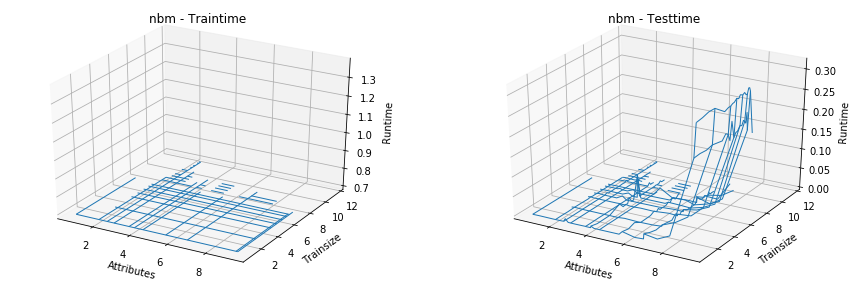

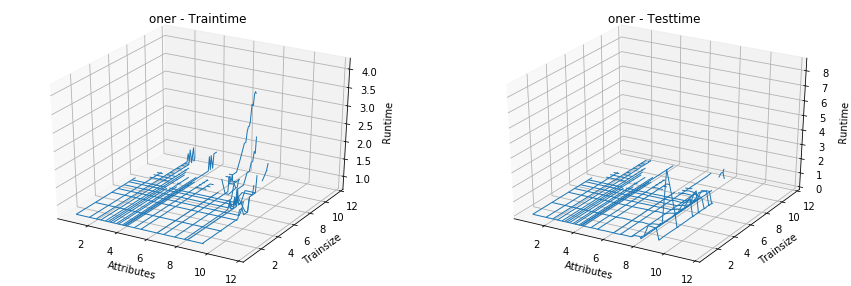

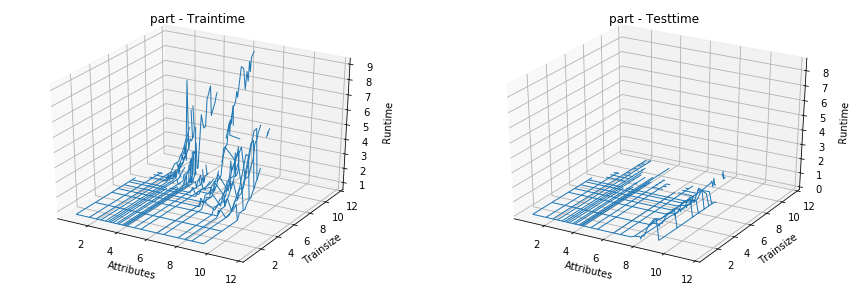

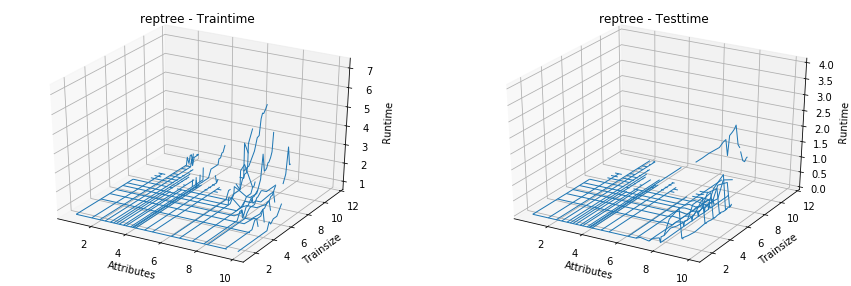

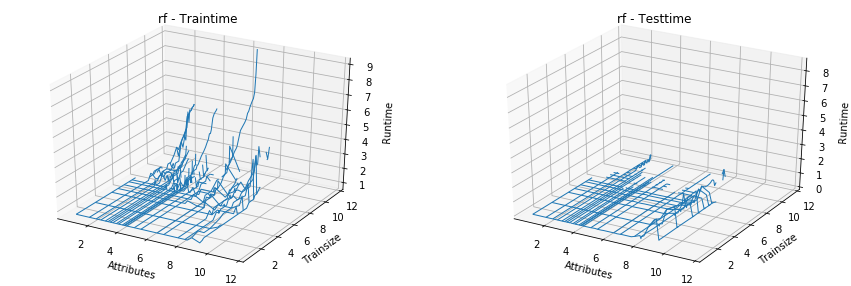

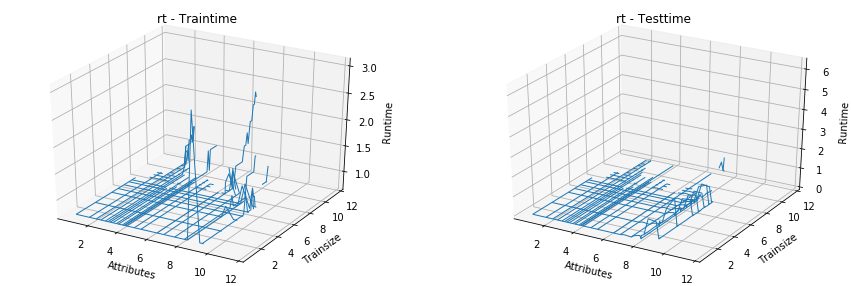

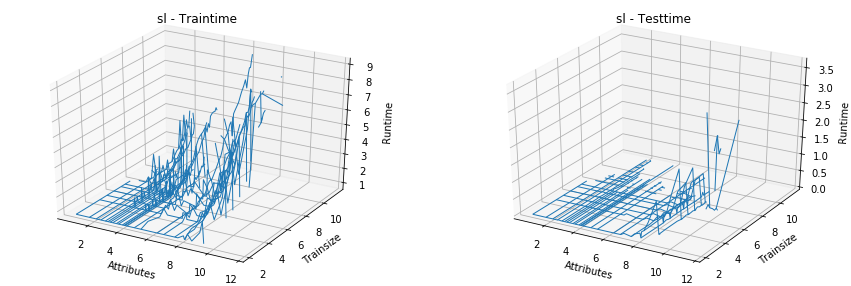

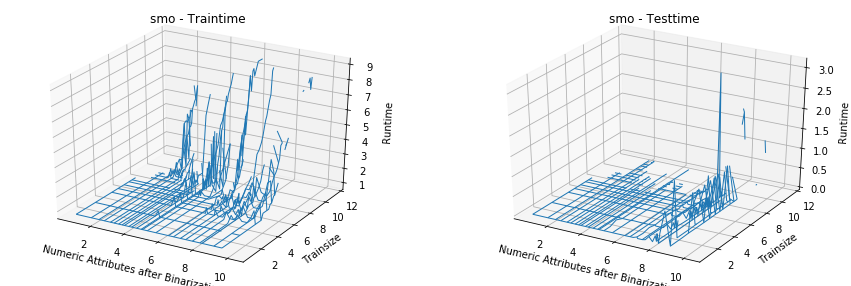

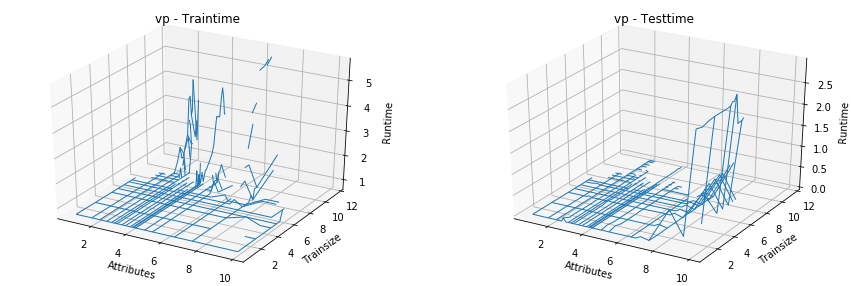

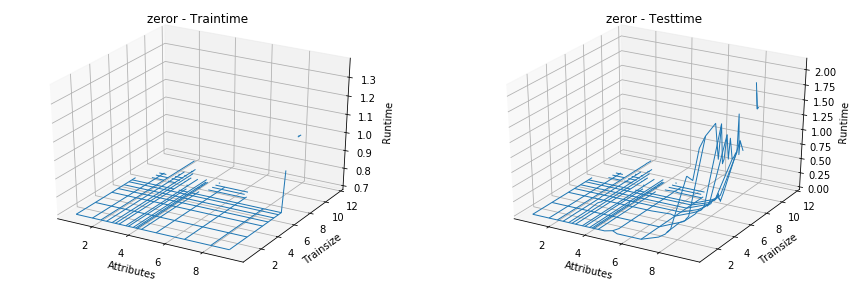

In [16]:
for k in overviews:
    classifierData = mfdf.query("classifier=='" + k + "'")
    trainpoints = np.log(np.unique(classifierData["trainpoints"]))
    attributeForAttributes = getAttributeForAttributesOfAlgorithm(k)
    attributes = np.log(np.unique(classifierData[attributeForAttributes]))
    
    traintimes = tableMean(overviews[k][0])
    testtimes = tableMean(overviews[k][1])
    
    X, Y = np.meshgrid(attributes, trainpoints)
    #adjustLimits(projection, ax)
    fig = plt.figure()
    for i, table in enumerate([traintimes, testtimes]):
        ax = fig.add_subplot(1, 2, (i + 1), projection='3d')
        fig.set_figheight(5)
        fig.set_figwidth(15)
        logtable = (table + 1).astype('float32')
        logtable = np.log(logtable)
        ax.plot_wireframe(X, Y, logtable, rstride=3, cstride=3, linewidth=1, antialiased=True)
        ax.set_xlabel('Attributes' if attributeForAttributes == "numattributes" else "Numeric Attributes after Binarization")
        ax.set_ylabel('Trainsize')
        ax.set_zlabel('Runtime')
        ax.set_title(k + " - " + ("Traintime" if i == 0 else "Testtime"))
    plt.show()
    plt.close()

# 2. Dispersion (Difficulty of the Learning Problem)

In [18]:
## FIRST STEP: Determining the dispersion (and "non-determinism") in the observed data
## Compute, for each classifier, the average variance in the execution times
import scipy
mstds = {}
stds = {}
for i, classifier in enumerate(tqdm(classifiers)):
    cdf = df.query("classifier == '" + classifier + "'")
    combinations = cdf[["openmlid", "trainpoints"]].drop_duplicates()
    observations = []
    for combo in combinations.values:
        runs = cdf.query("openmlid == '" + str(combo[0]) + "' and trainpoints == '" + str(combo[1]) + "'")[["traintime"]]
        var = np.std(runs.values)
        observations.append(var)
    mstds[classifier] = scipy.stats.trim_mean(observations, 0.05)
    stds[classifier] = np.std(cdf[["traintime"]].values)


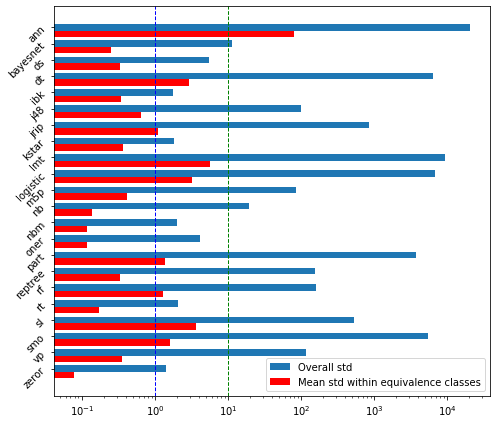

In [19]:
plt.figure(figsize=(7,6))
ind = np.arange(len(stds))
width=0.4
plt.barh(ind, list(stds.values()), width, label="Overall std")
plt.barh(ind + width, list(mstds.values()), width, color="red", label="Mean std within equivalence classes")
plt.yticks(range(len(stds)), list(stds.keys()), rotation=45)
plt.xscale("log")
plt.gca().invert_yaxis()
plt.axvline(1, color="blue", linestyle="--", linewidth="1")
plt.axvline(10, color="green", linestyle="--", linewidth="1")
plt.legend()
plt.tight_layout()
plt.savefig("basealg-stds.pdf")
plt.show()

## 3. Identification of Suitable Features to predict runtimes

In [8]:
candidates = ['numattributes', 'numlabels',
              #'numnumericattributes',
       #'numsymbolicattributes',
        'numberofcategories',
        'attributestocover50pctvariance'
       #'attributestocover90pctvariance', 'attributestocover95pctvariance',
       #'attributestocover99pctvariance'
        ]

basefeatures = ['numinstances', 'numericattributesafterbinarization']
#basefeatures.append(can)
#

In [25]:
updateGTPredictionPairSeries(datasets[:,0], classifiers, mfdf, "forest", range(3), [1, 10, 100, 1000, 10000], basefeatures, ["()"], trainsizes)

The classifier space has no values for openmlid 41066
The classifier space has no values for openmlid 41066
The classifier space has no values for openmlid 41066
The classifier space has no values for openmlid 41066
The classifier space has no values for openmlid 41066
The classifier space has no values for openmlid 41066
The classifier space has no values for openmlid 41066
The classifier space has no values for openmlid 41066
The classifier space has no values for openmlid 41066
The classifier space has no values for openmlid 41066
The classifier space has no values for openmlid 41066
The classifier space has no values for openmlid 41066
The classifier space has no values for openmlid 41066
The classifier space has no values for openmlid 41066
The classifier space has no values for openmlid 41066
No test data selected for openmlid 41065
No test data selected for openmlid 41065
No test data selected for openmlid 41065
No test data selected for openmlid 41065
No test data selected for 

The classifier space has no values for openmlid 1501
The classifier space has no values for openmlid 554
The classifier space has no values for openmlid 554
The classifier space has no values for openmlid 554
The classifier space has no values for openmlid 554
The classifier space has no values for openmlid 554
The classifier space has no values for openmlid 554
The classifier space has no values for openmlid 554
The classifier space has no values for openmlid 554
The classifier space has no values for openmlid 554
The classifier space has no values for openmlid 554
The classifier space has no values for openmlid 554
The classifier space has no values for openmlid 554
The classifier space has no values for openmlid 554
The classifier space has no values for openmlid 554
The classifier space has no values for openmlid 554
The classifier space has no values for openmlid 1457
The classifier space has no values for openmlid 1457
The classifier space has no values for openmlid 1457
The clas

The classifier space has no values for openmlid 41026
The classifier space has no values for openmlid 41026
The classifier space has no values for openmlid 41026
The classifier space has no values for openmlid 41026
The classifier space has no values for openmlid 41026
The classifier space has no values for openmlid 41026
The classifier space has no values for openmlid 41026
The classifier space has no values for openmlid 41026
The classifier space has no values for openmlid 41026
The classifier space has no values for openmlid 41026
The classifier space has no values for openmlid 41026
The classifier space has no values for openmlid 41026
The classifier space has no values for openmlid 41026
The classifier space has no values for openmlid 41026
The classifier space has no values for openmlid 1485
The classifier space has no values for openmlid 1485
The classifier space has no values for openmlid 1485
The classifier space has no values for openmlid 1485
The classifier space has no valu

The classifier space has no values for openmlid 40927
The classifier space has no values for openmlid 40927
The classifier space has no values for openmlid 40927
The classifier space has no values for openmlid 40927
The classifier space has no values for openmlid 40927
The classifier space has no values for openmlid 40927
The classifier space has no values for openmlid 40927
The classifier space has no values for openmlid 40927
The classifier space has no values for openmlid 40927
The classifier space has no values for openmlid 40927
The classifier space has no values for openmlid 40927
The classifier space has no values for openmlid 40927
The classifier space has no values for openmlid 181
The classifier space has no values for openmlid 181
The classifier space has no values for openmlid 181
The classifier space has no values for openmlid 181
The classifier space has no values for openmlid 181
The classifier space has no values for openmlid 181
The classifier space has no values for o

The classifier space has no values for openmlid 1216
The classifier space has no values for openmlid 1216
The classifier space has no values for openmlid 1216
The classifier space has no values for openmlid 1216
The classifier space has no values for openmlid 1216
The classifier space has no values for openmlid 1216
The classifier space has no values for openmlid 1216
The classifier space has no values for openmlid 1216
The classifier space has no values for openmlid 1042
The classifier space has no values for openmlid 1042
The classifier space has no values for openmlid 1042
The classifier space has no values for openmlid 1042
The classifier space has no values for openmlid 1042
The classifier space has no values for openmlid 1042
The classifier space has no values for openmlid 1042
The classifier space has no values for openmlid 1042
The classifier space has no values for openmlid 1042
The classifier space has no values for openmlid 1042
The classifier space has no values for openmli

The classifier space has no values for openmlid 41991
The classifier space has no values for openmlid 41991
The classifier space has no values for openmlid 41991
The classifier space has no values for openmlid 41991
The classifier space has no values for openmlid 41991
The classifier space has no values for openmlid 41991
The classifier space has no values for openmlid 41991
The classifier space has no values for openmlid 41991
The classifier space has no values for openmlid 41991
The classifier space has no values for openmlid 41991
The classifier space has no values for openmlid 41991
The classifier space has no values for openmlid 41991
The classifier space has no values for openmlid 41991
The classifier space has no values for openmlid 41991
The classifier space has no values for openmlid 41991
The classifier space has no values for openmlid 41991
The classifier space has no values for openmlid 41991
The classifier space has no values for openmlid 41991
The classifier space has no 

The classifier space has no values for openmlid 1112
The classifier space has no values for openmlid 1112
The classifier space has no values for openmlid 1112
The classifier space has no values for openmlid 1112
The classifier space has no values for openmlid 1112
The classifier space has no values for openmlid 1112
The classifier space has no values for openmlid 1112
The classifier space has no values for openmlid 1112
The classifier space has no values for openmlid 1112
The classifier space has no values for openmlid 1112
The classifier space has no values for openmlid 1112
The classifier space has no values for openmlid 1112
The classifier space has no values for openmlid 1112
The classifier space has no values for openmlid 1112
The classifier space has no values for openmlid 1112
The classifier space has no values for openmlid 1112
The classifier space has no values for openmlid 1112
The classifier space has no values for openmlid 1112
The classifier space has no values for openmli

The classifier space has no values for openmlid 1114
The classifier space has no values for openmlid 1114
The classifier space has no values for openmlid 1114
The classifier space has no values for openmlid 1114
The classifier space has no values for openmlid 1114
The classifier space has no values for openmlid 1114
The classifier space has no values for openmlid 1114
The classifier space has no values for openmlid 1114
The classifier space has no values for openmlid 1114
The classifier space has no values for openmlid 1114
The classifier space has no values for openmlid 1114
The classifier space has no values for openmlid 1114
The classifier space has no values for openmlid 1114
The classifier space has no values for openmlid 1114
The classifier space has no values for openmlid 1114
The classifier space has no values for openmlid 1114
The classifier space has no values for openmlid 1114
The classifier space has no values for openmlid 1114
The classifier space has no values for openmli

The classifier space has no values for openmlid 18
The classifier space has no values for openmlid 18
The classifier space has no values for openmlid 18
The classifier space has no values for openmlid 21
The classifier space has no values for openmlid 21
The classifier space has no values for openmlid 21
The classifier space has no values for openmlid 21
The classifier space has no values for openmlid 21
The classifier space has no values for openmlid 21
The classifier space has no values for openmlid 21
The classifier space has no values for openmlid 21
The classifier space has no values for openmlid 21
The classifier space has no values for openmlid 21
The classifier space has no values for openmlid 21
The classifier space has no values for openmlid 21
The classifier space has no values for openmlid 21
The classifier space has no values for openmlid 21
The classifier space has no values for openmlid 21
The classifier space has no values for openmlid 22
The classifier space has no val

The classifier space has no values for openmlid 179
The classifier space has no values for openmlid 179
The classifier space has no values for openmlid 179
The classifier space has no values for openmlid 179
The classifier space has no values for openmlid 179
The classifier space has no values for openmlid 179
The classifier space has no values for openmlid 179
The classifier space has no values for openmlid 180
The classifier space has no values for openmlid 180
The classifier space has no values for openmlid 180
The classifier space has no values for openmlid 180
The classifier space has no values for openmlid 180
The classifier space has no values for openmlid 180
The classifier space has no values for openmlid 180
The classifier space has no values for openmlid 180
The classifier space has no values for openmlid 180
The classifier space has no values for openmlid 180
The classifier space has no values for openmlid 180
The classifier space has no values for openmlid 180
The classifi

The classifier space has no values for openmlid 390
The classifier space has no values for openmlid 390
The classifier space has no values for openmlid 390
The classifier space has no values for openmlid 390
The classifier space has no values for openmlid 390
The classifier space has no values for openmlid 390
The classifier space has no values for openmlid 390
The classifier space has no values for openmlid 390
The classifier space has no values for openmlid 390
The classifier space has no values for openmlid 390
The classifier space has no values for openmlid 390
The classifier space has no values for openmlid 390
The classifier space has no values for openmlid 390
The classifier space has no values for openmlid 390
The classifier space has no values for openmlid 390
The classifier space has no values for openmlid 390
The classifier space has no values for openmlid 390
The classifier space has no values for openmlid 390
The classifier space has no values for openmlid 390
The classifi

The classifier space has no values for openmlid 399
The classifier space has no values for openmlid 399
The classifier space has no values for openmlid 399
The classifier space has no values for openmlid 399
The classifier space has no values for openmlid 399
The classifier space has no values for openmlid 399
The classifier space has no values for openmlid 399
The classifier space has no values for openmlid 399
The classifier space has no values for openmlid 401
The classifier space has no values for openmlid 401
The classifier space has no values for openmlid 401
The classifier space has no values for openmlid 401
The classifier space has no values for openmlid 401
The classifier space has no values for openmlid 401
The classifier space has no values for openmlid 401
The classifier space has no values for openmlid 401
The classifier space has no values for openmlid 401
The classifier space has no values for openmlid 401
The classifier space has no values for openmlid 401
The classifi

TypeError: argument of type 'int' is not iterable

**TODO**: Checke für alle subsets der aktuellen features auf 10 datensätzen mit 5 classifiern, wie gut die performance ist, um die idealen Feature zu bestimmen. Das wären 10 * 5 * 2^10 = 50*1024 = 50000 Auswertungen.

Wahrscheinlich zu viel. Wir könnten erstmal bestimmte Teilmengen probieren (erstmal nur einzelne features, dann die zweier-Kombinationen, dann dreier-Kombinationen). Das wären dann 50 * (10 + 55) = 3000 Auswertungen.

Das sieht machbar aus. Trotzdem gestaffelt vorgehen: Erstmal NUR die mit einem feature.

In [9]:
anDF = pd.read_csv("runtime_predictions.csv")

In [10]:
featureCombos = pd.unique(anDF["basefeatures"])
numRows = len(datasets[0:10,0]) * len(classifiers[0:5])
M = np.zeros((numRows, len(featureCombos)))
row = 0
for d in datasets[0:10,0]:
    for c in classifiers[0:5]:
        fDF = anDF.query("openmlid == " + str(d) + " and algorithm == '" + c + "' and trainpoints_algorithm == '100'")
        if len(fDF) > 0:
            gt = list(map(float, fDF.query("recordtype == 'traintime_gt'").iloc[0]["entries"].split(";")))
            col = 0
            for fc in featureCombos:
                expDF = fDF.query("basefeatures == '" + fc.replace("'", "\\'") + "' and recordtype == 'traintime_pr'")
                predictionsForSeeds = expDF["entries"]
                vals = []
                for pred in predictionsForSeeds:
                    predAsNumbers = list(map(float, pred.split(";")))
                    vals.append(RDIST(gt, predAsNumbers))
                M[row][col] = np.mean(vals)
                col += 1
            row += 1

/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


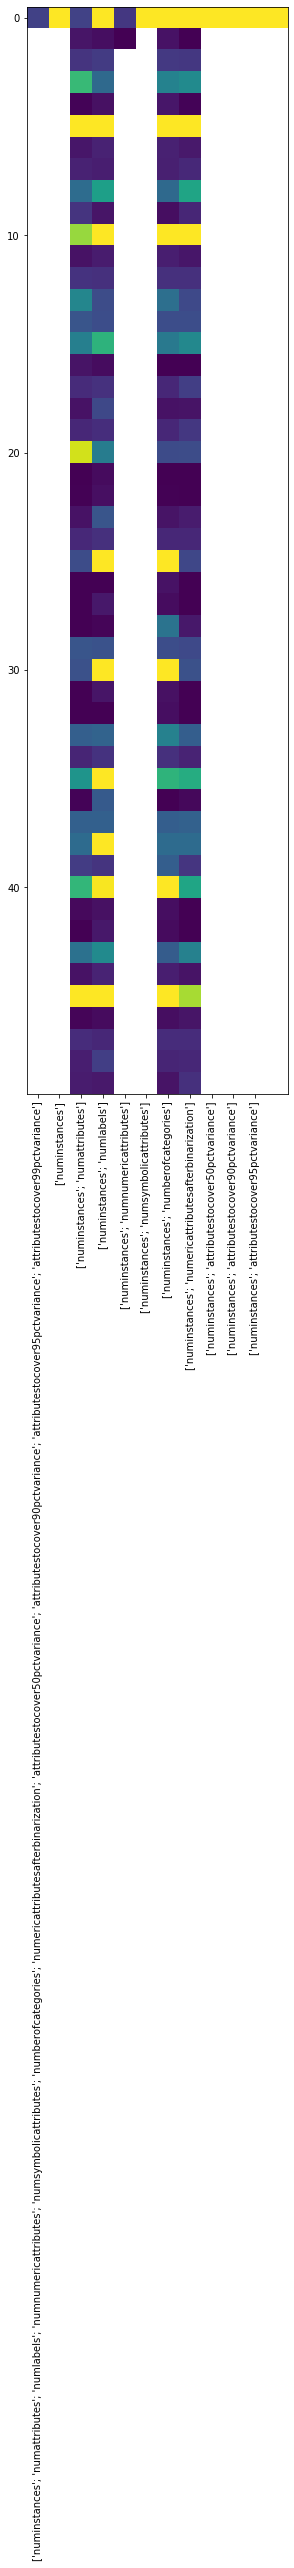

In [11]:
import matplotlib.pyplot as plt

# what is the train and test time of the classifiers on different datasets for 70/30 splits?
fig, ax = plt.subplots(1, 1, figsize=(20,20))
a = ax
im = a.imshow(M, cmap='viridis', vmin=0, vmax=1)
a.set_xticks(np.arange(len(featureCombos) - 1))
a.set_xticklabels(featureCombos, rotation=90)
pass

**Conclusion**: The above experiments strongly suggest that the best is **only to use two** features:
* number of instances
* number of attributes after binarization

This is even better than using a strict superset of these features (even with than 10k training points!)!

# 3. Generalization Performance for Full Knowledge Exploitation

In [12]:
dDatasets, cClassifiers, trainGTPredictionPairs, testGTPredictionPairs = getGTPredictionPairSeries("forest", ['numinstances', 'numericattributesafterbinarization'], (), 10000)

In [13]:
def overMAPE(A, F):
    n = 0
    s = 0
    for i in range(len(A)):
        if A[i] <= F[i] and A[i] > 10:
            s += (F[i] - A[i]) / A[i]
            n+=1
    return s / n if n > 0 else 0

def underMAPE(A, F):
    n = 0
    s = 0
    for i in range(len(A)):
        if A[i] >= F[i] and F[i] > 10:
            s += (A[i] - F[i]) / F[i]
            n+=1
    return s / n if n > 0 else 0

In [14]:
def getAllMetrics(datasets, classifiers, data_train, data_pred):
    metrics = {}
    for measure in [RMSE, SMAPE, RDIST, overMAPE, underMAPE]:
        measureName = str(measure.__name__)
        metrics[measureName] = {}
        metrics[measureName]['train'] = getMeasureForDatasetClassifierPairs(datasets, classifiers, data_train, measure)
        metrics[measureName]['test'] = getMeasureForDatasetClassifierPairs(datasets, classifiers, data_pred, measure)
    return metrics

In [15]:
metrics = getAllMetrics(dDatasets, cClassifiers, trainGTPredictionPairs, testGTPredictionPairs)

## 3.1. RMSE of RF for leave-one-out

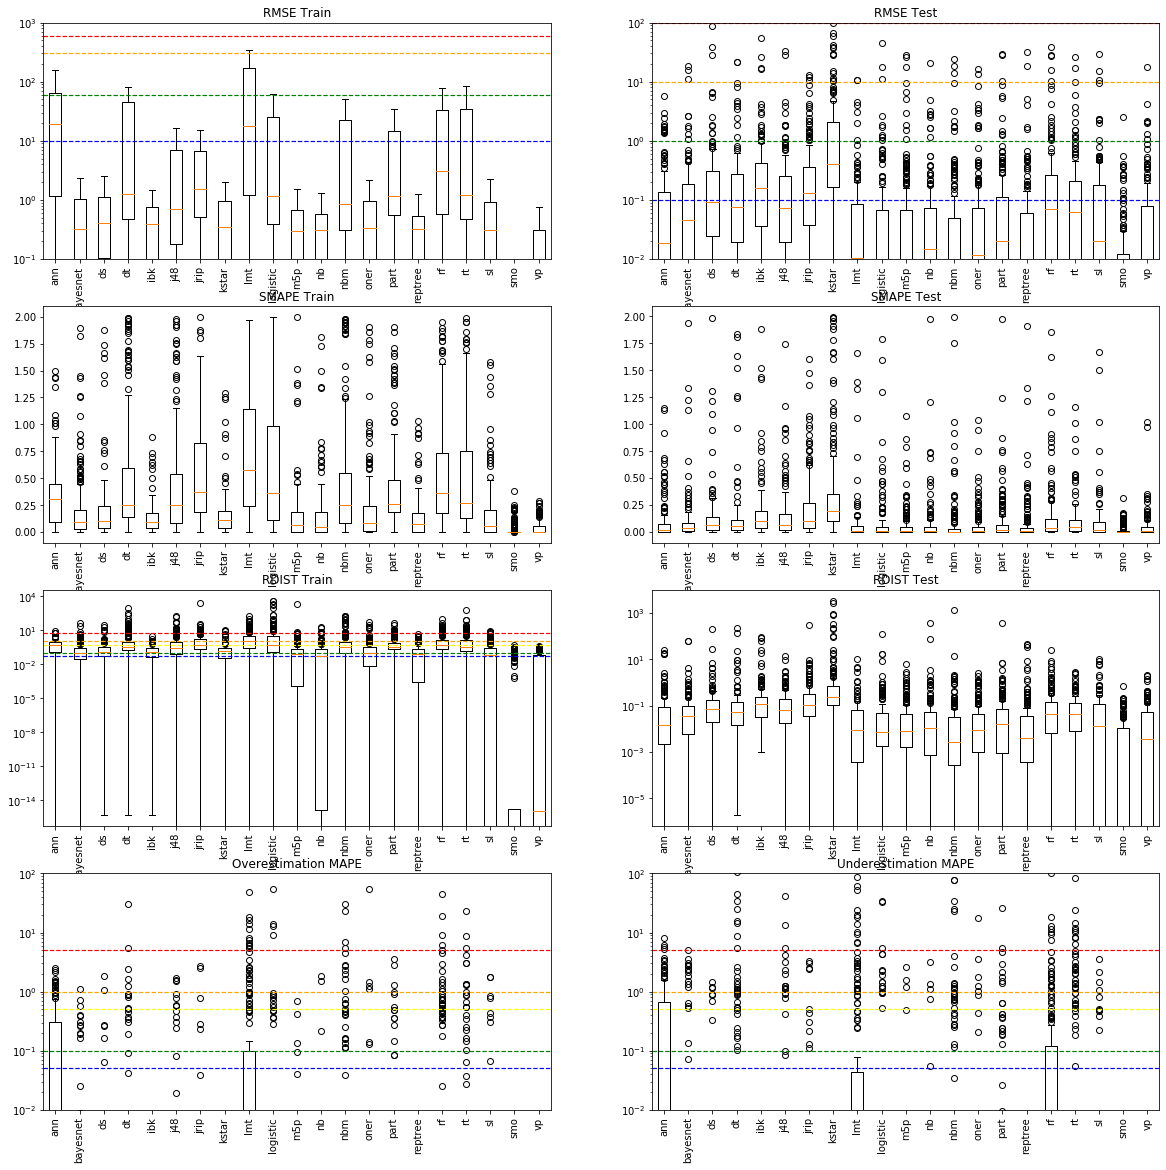

In [17]:
fig, ax = plt.subplots(4,2,figsize=(20,20))
a = ax[0][0]
a.boxplot(metrics["RMSE"]["train"], 0, '')
a.set_xticklabels(classifiers, rotation=90)
a.set_ylim([.1, 1000])
a.set_yscale('log')
a.set_title("RMSE Train")
a.axhline(10, color="blue", linestyle="--", linewidth="1.2")
a.axhline(60, color="green", linestyle="--", linewidth="1.2")
a.axhline(300, color="orange", linestyle="--", linewidth="1.2")
a.axhline(600, color="red", linestyle="--", linewidth="1.2")
a = ax[0][1]
a.boxplot(metrics["RMSE"]["test"])
a.set_xticklabels(classifiers, rotation=90)
a.set_yscale('log')
a.set_ylim([.01, 100])
a.set_title("RMSE Test")
a.axhline(0.1, color="blue", linestyle="--", linewidth="1.2")
a.axhline(1, color="green", linestyle="--", linewidth="1.2")
a.axhline(10, color="orange", linestyle="--", linewidth="1.2")
a.axhline(100, color="red", linestyle="--", linewidth="1.2")
a = ax[1][0]
a.boxplot(metrics["SMAPE"]["train"])
a.set_xticklabels(classifiers, rotation=90)
a.set_title("SMAPE Train")
a = ax[1][1]
a.boxplot(metrics["SMAPE"]["test"])
a.set_xticklabels(classifiers, rotation=90)
a.set_title("SMAPE Test")
a = ax[2][0]
a.boxplot(metrics["RDIST"]["train"])
a.set_xticklabels(classifiers, rotation=90)
a.set_title("RDIST Train")
a.axhline(0.05, color="blue", linestyle="--", linewidth="1.2")
a.axhline(0.1, color="green", linestyle="--", linewidth="1.2")
a.axhline(0.5, color="yellow", linestyle="--", linewidth="1.2")
a.axhline(1, color="orange", linestyle="--", linewidth="1.2")
a.axhline(5, color="red", linestyle="--", linewidth="1.2")
a.set_yscale('log')
a = ax[2][1]
a.boxplot(metrics["RDIST"]["test"])
a.set_xticklabels(classifiers, rotation=90)
a.set_title("RDIST Test")
a.set_yscale('log')

# over MAPE / under MAPE
a = ax[3][0]
a.boxplot(np.maximum(0.000000001, metrics["overMAPE"]["train"]))
a.set_xticklabels(classifiers, rotation=90)
a.set_title("Overestimation MAPE")
a.set_yscale('log')
a.set_ylim([.01, 100])
a.axhline(0.05, color="blue", linestyle="--", linewidth="1.2")
a.axhline(0.1, color="green", linestyle="--", linewidth="1.2")
a.axhline(0.5, color="yellow", linestyle="--", linewidth="1.2")
a.axhline(1, color="orange", linestyle="--", linewidth="1.2")
a.axhline(5, color="red", linestyle="--", linewidth="1.2")
a = ax[3][1]
a.boxplot(np.maximum(0.000000001, metrics["underMAPE"]["train"]))
a.set_xticklabels(classifiers, rotation=90)
a.set_title("Underestimation MAPE")
a.set_yscale('log')
a.set_ylim([.01, 100])
a.axhline(0.05, color="blue", linestyle="--", linewidth="1.2")
a.axhline(0.1, color="green", linestyle="--", linewidth="1.2")
a.axhline(0.5, color="yellow", linestyle="--", linewidth="1.2")
a.axhline(1, color="orange", linestyle="--", linewidth="1.2")
a.axhline(5, color="red", linestyle="--", linewidth="1.2")
pass

**todo**: Überschätzung/Unterschätzung in Abhängigkeit des Datensatzes anschauen. Evtl. auch die Abweichungen anderer Algorithmen berücksichtigen.

## 3.2. Percentage of Predictions within a given maximum RMSE

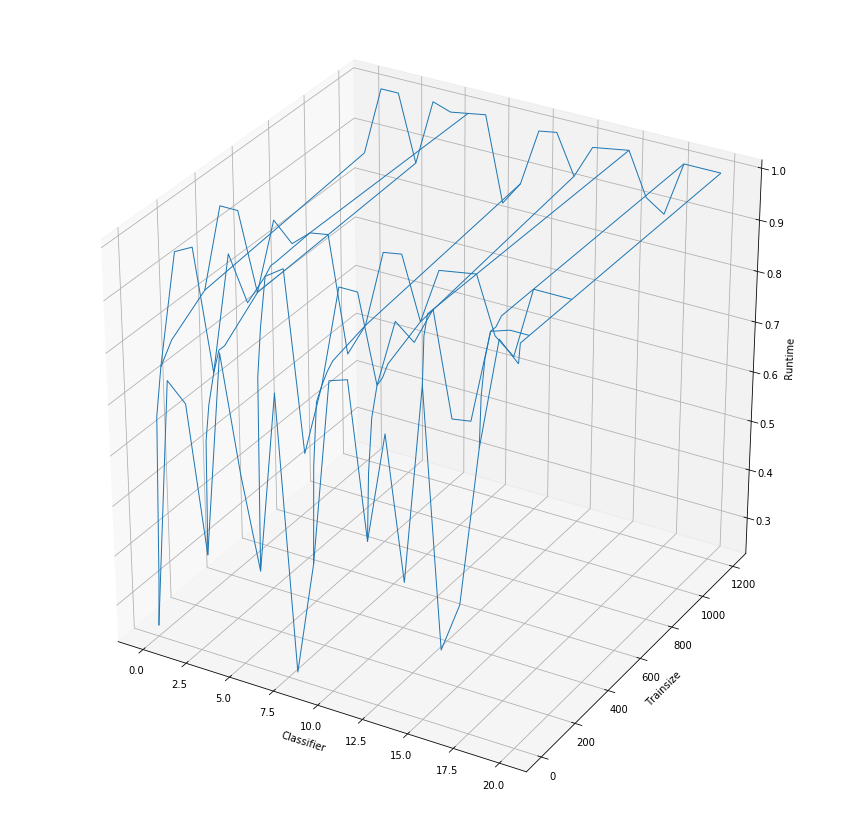

In [18]:
covSpace = [1, 10, 30, 60, 90, 120, 300, 1200]
X, Y = np.meshgrid(range(len(cClassifiers)), covSpace)
trainCoverage = np.zeros((len(covSpace), len(cClassifiers)))
for i, c in enumerate(cClassifiers):
    for j, cov in enumerate(covSpace):
        trainCoverage[j,i] = np.count_nonzero(metrics['RMSE']['train'][:,i] <= cov) / len(metrics['RMSE']['train'][:,i])
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(X, Y, trainCoverage, rstride=3, cstride=3, linewidth=1, antialiased=True)
ax.set_xlabel('Classifier')
ax.set_ylabel('Trainsize')
ax.set_zlabel('Runtime')
pass

## 3.3. Critical over- and understimations of the predictor
Idea:
* Even large absolute prediction failures are **ok** if both prediction and true runtime are substantially beyond the timeout.
* Prediction failures are a **problem** if the timeout is between prediction and true timeout

We should check the timeout is between prediction and truth when
* the absolute error is large
* the absolute error is small 

In [19]:
def getTotalPairs(pairs):
    c = 0
    for seed in range(len(pairs)):
        c += len(pairs[seed][0])
    return c
    
def retainCriticallyMissEstimations(pairs, timeout):
    reducedPairsOverestimation = []
    reducedPairsUnderestimation = []
    allErrored = []
    if type(pairs) == list and len(pairs) > 0:
        for seed in range(len(pairs)):
            gt = pairs[seed][0]
            pr = pairs[seed][1]
            toArray = np.ravel(np.full((len(gt), 1), to))
            overestimateMiss = np.where((gt < toArray) & (toArray < pr))[0]
            reducedPairsOverestimation.append((gt[overestimateMiss], pr[overestimateMiss]))
            underestimateMiss = np.where((gt > toArray) & (toArray > pr))[0]
            reducedPairsUnderestimation.append((gt[underestimateMiss], pr[underestimateMiss]))
            erroredGT = []
            erroredGT.extend(gt[overestimateMiss])
            erroredGT.extend(gt[underestimateMiss])
            erroredPR = []
            erroredPR.extend(pr[overestimateMiss])
            erroredPR.extend(pr[underestimateMiss])
            allErrored.append((erroredGT, erroredPR))
    return allErrored, reducedPairsOverestimation, reducedPairsUnderestimation

timeouts = np.linspace(10, 1800, 101)
overestimates = np.zeros((len(cClassifiers), len(timeouts), len(dDatasets)))
underestimates = np.zeros((len(cClassifiers), len(timeouts), len(dDatasets)))
for j, c in enumerate(cClassifiers):
    for k, to in enumerate(timeouts):
        for i, d in enumerate(dDatasets):
            if type(trainGTPredictionPairs[i][j]) == list and len(trainGTPredictionPairs[i][j]) > 0:
                allerrored, overpairs, underpairs = retainCriticallyMissEstimations(trainGTPredictionPairs[i][j], to)
                for seed in range(len(overpairs)):
                    overestimates[j][k][i] += len(overpairs[seed][0])
                    underestimates[j][k][i] += len(underpairs[seed][0])
                totalCounts = getTotalPairs(trainGTPredictionPairs[i][j])
                if totalCounts < overestimates[j][k][i] or totalCounts < overestimates[j][k][i]:
                    raise Exception("Cannot have more over/underestimates than counts")
                overestimates[j][k][i] /= totalCounts
                underestimates[j][k][i] /= totalCounts

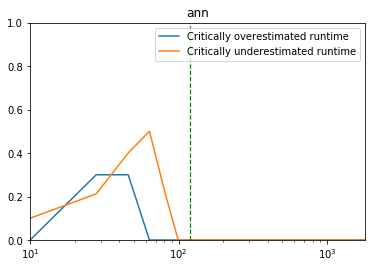

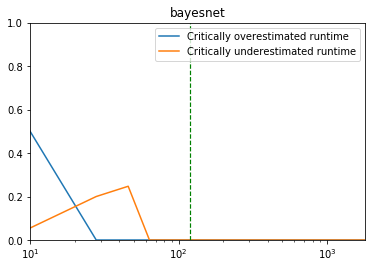

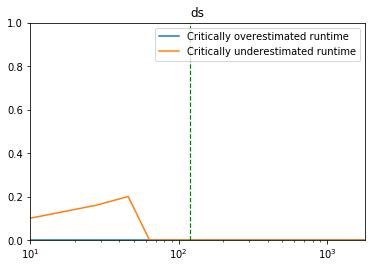

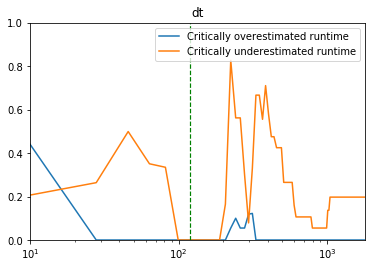

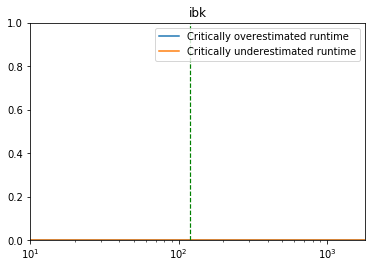

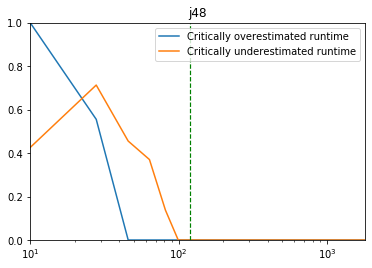

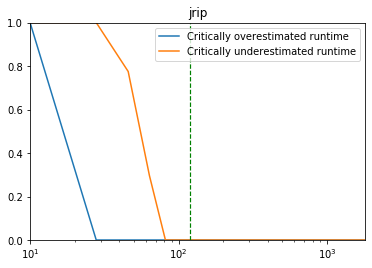

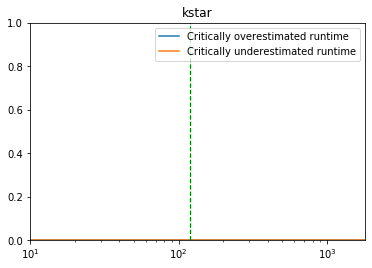

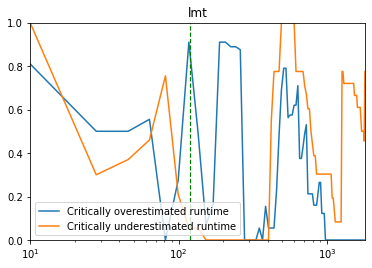

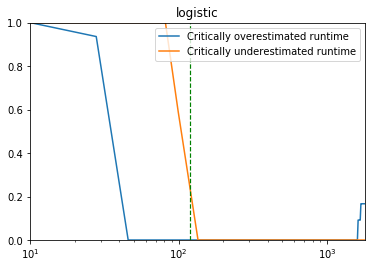

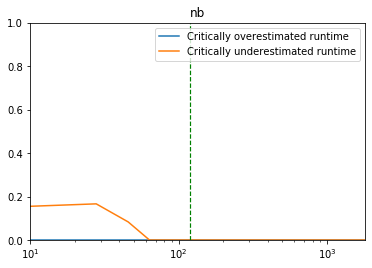

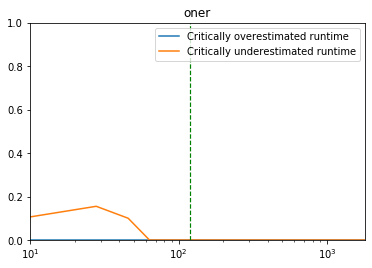

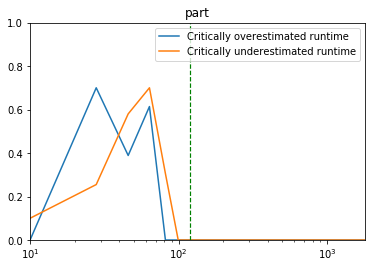

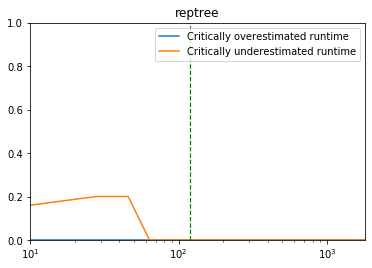

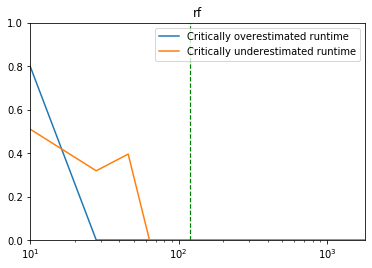

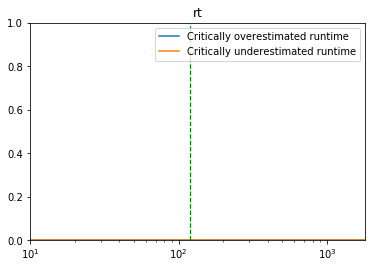

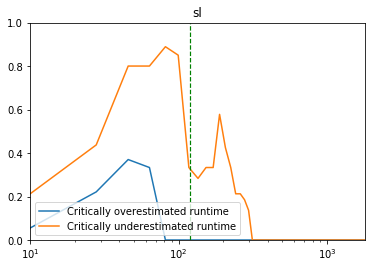

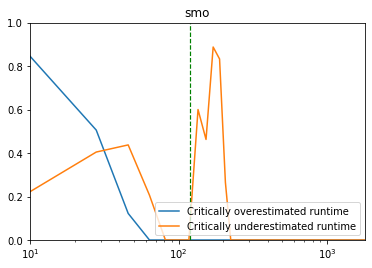

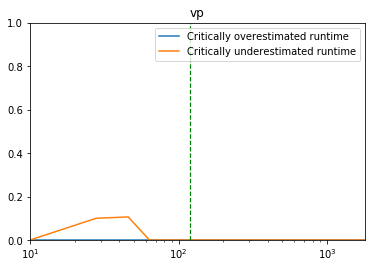

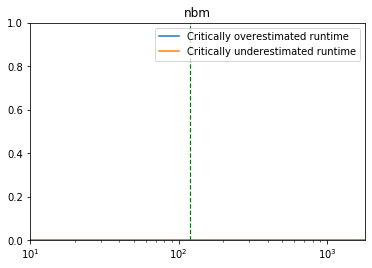

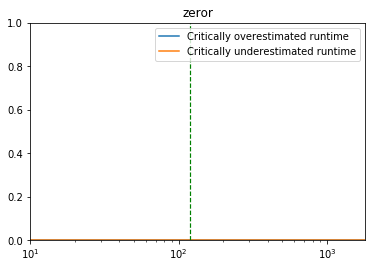

In [21]:
for i, c in enumerate(cClassifiers):
    plt.figure()
    plt.plot(timeouts, np.quantile(overestimates[i], .95, axis=1))
    plt.plot(timeouts, np.quantile(underestimates[i], .95, axis=1))
    plt.title(c)
    #plt.yscale("log")
    plt.xlim([10,1800])
    plt.ylim([0,1])
    plt.xscale("log")
    plt.axvline(120, color="green", linestyle="--", linewidth="1.2")
    plt.legend(["Critically overestimated runtime", "Critically underestimated runtime"])
    plt.show()
    plt.close()

**Conclusion**: In my view, the above results say the following: For a timeout of 2 minutes or more, the risk that a critical error occurs in the prediction is quite small (less than 5% except on decision tables). Of course, there may still be errors. But typically these are not crtitical with respect to executability.

**Note**: We have not considered a conservative prediction here (assuming e.g. runtime up to 2 times higher than the one predicted).

## 3.4. Can we predict whether the predict will (substantially) overestimate or underestimate?

In [22]:
pDatasets, pClassifiers, pTrainDiff, pPredictDiff = dDatasets, cClassifiers, trainGTPredictionPairs, testGTPredictionPairs

In [23]:
relevantAttributes = ["openmlid", "classifier", "seed", "trainpoints", "factor", 'numattributes', 'numlabels', 'numnumericattributes',
       'numsymbolicattributes', 'numberofcategories',
       'numericattributesafterbinarization', 'attributestocover50pctvariance',
       'attributestocover90pctvariance', 'attributestocover95pctvariance',
       'attributestocover99pctvariance', 'accvariancerel1', 'accvariancerel2',
       'accvariancerel3', 'accvariancerel4', 'accvariancerel5',
       'accvariancerel6', 'accvariancerel7', 'accvariancerel8',
       'accvariancerel9', 'accvariancerel10', 'accvarianceabs1',
       'accvarianceabs2', 'accvarianceabs3', 'accvarianceabs4',
       'accvarianceabs5', 'accvarianceabs6', 'accvarianceabs7',
       'accvarianceabs8', 'accvarianceabs9', 'accvarianceabs10',
       'totalvariance', "overestimated"]

In [24]:
overestimateDF = pd.DataFrame(columns=["openmlid", "classifier", "seed", "factor", "overestimated"])
underestimateDF = pd.DataFrame(columns=["openmlid", "classifier", "seed", "factor", "underestimated"])
for f in range(1):
    f += 1
    print(f)
    for i, d in enumerate(tqdm(pDatasets)):
        for j, c in enumerate(pClassifiers):
            for seed in range(len(pTrainDiff[i][j])):
                for k, pr in enumerate(pTrainDiff[i][j][seed][1]):
                    gt = pTrainDiff[i][j][seed][0][k]
                    if pr >= gt:
                        MAPE = (pr - gt)/ gt
                        if MAPE > f:
                            overestimateDF.loc[len(overestimateDF)] = [d, c, seed, f, 1]
                        else:
                            overestimateDF.loc[len(overestimateDF)] = [d, c, seed, f, 0]
                    if pr <= gt:
                        MAPE = (gt - pr)/ pr
                        if MAPE > f:
                            underestimateDF.loc[len(underestimateDF)] = [d, c, seed, f, 1]
                        else:
                            underestimateDF.loc[len(underestimateDF)] = [d, c, seed, f, 0]

1


In [195]:
pDF = underestimateDF.query("factor == 1").merge(mfdf, on=["openmlid", "classifier", "seed"])

In [206]:
underestimateDF.drop_duplicates().query("classifier == 'ann' and seed == 0")

openmlid classifier seed factor underestimated
0        41066        ann    0      1              0
419          3        ann    0      1              0
421          3        ann    0      1              1
459         31        ann    0      1              1
489         60        ann    0      1              0
...        ...        ...  ...    ...            ...
17497     1067        ann    0      2              1
17526     1069        ann    0      2              0
17551     1119        ann    0      2              0
17588     1120        ann    0      2              0
17624    41066        ann    0      3              0

[307 rows x 5 columns]

In [196]:
estData = pd.DataFrame()
for d in tqdm(datasets):
    maxTrainpoints = np.max(pDF.query("openmlid == " + str(d[0]))["trainpoints"])
    if not np.isnan(maxTrainpoints):
        estData = pd.concat([estData, pDF.query("openmlid == " + str(d[0]) + " and trainpoints == " +str(maxTrainpoints)).drop_duplicates()])

In [197]:
## Overstestimation predictor
for c in np.unique(estData["classifier"]):
    tdDF = estData.query("classifier == '" + c + "' and factor == 1")
    rf = sk.ensemble.RandomForestClassifier(n_estimators=100)
    #print(tdDF.columns)
    X = tdDF[["trainpoints", 'numericattributesafterbinarization']].values
    Y = tdDF["underestimated"].values.astype("int")
    print(c + ": " + str(np.mean(sk.model_selection.cross_validate(rf, X, Y, cv=10)["test_score"])))

ann: 0.4797794117647058
bayesnet: 0.6993006993006994
ds: 0.6700549450549451
dt: 0.5328022875816993
ibk: 0.6141025641025641


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


j48: 0.6666666666666666


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


jrip: 0.8166666666666667
kstar: 0.5038461538461538
lmt: 0.5110989010989011
logistic: 0.5276190476190475
nb: 0.6144444444444445


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


nbm: 0.9800000000000001
oner: 0.7925252525252526
part: 0.6972610722610723
reptree: 0.6143939393939395
rf: 0.6687426900584794
rt: 0.6416666666666667
sl: 0.5795751633986927
smo: 0.5933333333333334
vp: 0.5844444444444445
zeror: 0.8200000000000001


# 3.x. Learning Curves for Basic Algorithms

In [62]:
mfdf

openmlid  datapoints_x  trainpoints  testpoints  seed classifier  \
0          41066          1567            2        1565     0   bayesnet   
1          41066          1567            2        1565     0         ds   
2          41066          1567            2        1565     0         dt   
3          41066          1567            2        1565     0        ibk   
4          41066          1567            2        1565     0      kstar   
...          ...           ...          ...         ...   ...        ...   
297746      1120         19020         5000       14020     5      kstar   
297747      1120         19020         5000       14020     7         ds   
297748      1120         19020         5000       14020     7         dt   
297749      1120         19020         5000       14020     7        ibk   
297750      1120         19020         5000       14020     7      kstar   

        traintime  testtime  datapoints_y  numinstances  ...  accvarianceabs3  \
0             1.0       2.0             2           2.0  ...     5.663569e+06   
1             1.0      68.0             2           2.0  ...     5.663569e+06   
2             1.0      80.0             2           2.0  ...     5.663569e+06   
3             1.0      42.0             2           2.0  ...     5.663569e+06   
4             1.0       2.0             2           2.0  ...     5.663569e+06   
...           ...       ...           ...           ...  ...              ...   
297746        1.0    2619.0          5000        5000.0  ...     3.131044e+07   
297747        1.0       1.0          5000        5000.0  ...     3.129756e+07   
297748        1.0       7.0          5000        5000.0  ...     3.129756e+07   
297749        1.0       8.0          5000        5000.0  ...     3.129756e+07   
297750        1.0    2907.0          5000        5000.0  ...     3.129756e+07   

        accvarianceabs4  accvarianceabs5  accvarianceabs6  accvarianceabs7  \
0          5.940430e+06     6.148597e+06     6.286460e+06     6.408824e+06   
1          5.940430e+06     6.148597e+06     6.286460e+06     6.408824e+06   
2          5.940430e+06     6.148597e+06     6.286460e+06     6.408824e+06   
3          5.940430e+06     6.148597e+06     6.286460e+06     6.408824e+06   
4          5.940430e+06     6.148597e+06     6.286460e+06     6.408824e+06   
...                 ...              ...              ...              ...   
297746     3.131310e+07     3.131489e+07     3.131556e+07     3.131599e+07   
297747     3.130022e+07     3.130201e+07     3.130268e+07     3.130311e+07   
297748     3.130022e+07     3.130201e+07     3.130268e+07     3.130311e+07   
297749     3.130022e+07     3.130201e+07     3.130268e+07     3.130311e+07   
297750     3.130022e+07     3.130201e+07     3.130268e+07     3.130311e+07   

        accvarianceabs8  accvarianceabs9  accvarianceabs10  totalvariance  \
0          6.526566e+06     6.630078e+06      6.677203e+06   7.077074e+06   
1          6.526566e+06     6.630078e+06      6.677203e+06   7.077074e+06   
2          6.526566e+06     6.630078e+06      6.677203e+06   7.077074e+06   
3          6.526566e+06     6.630078e+06      6.677203e+06   7.077074e+06   
4          6.526566e+06     6.630078e+06      6.677203e+06   7.077074e+06   
...                 ...              ...               ...            ...   
297746     3.131634e+07     3.131634e+07      3.131634e+07   3.131634e+07   
297747     3.130346e+07     3.130346e+07      3.130346e+07   3.130346e+07   
297748     3.130346e+07     3.130346e+07      3.130346e+07   3.130346e+07   
297749     3.130346e+07     3.130346e+07      3.130346e+07   3.130346e+07   
297750     3.130346e+07     3.130346e+07      3.130346e+07   3.130346e+07   

        testtimeperinstance  
0                  0.001278  
1                  0.043450  
2                  0.051118  
3                  0.026837  
4                  0.001278  
...                     ...  
297746             0.186805  
297747             0